In [1]:
import sys
import os

# Get the current working directory
notebook_path = os.getcwd()
# Go up two directory level to reach the project root
project_root = os.path.dirname(os.path.dirname(notebook_path))
# Add project root to Python path
sys.path.append(project_root)

import time
import torch
import math
import numpy as np
from tqdm import tqdm
from torch import nn, Tensor

# flow_matching
from flow_matching.path import GeodesicProbPath, AffineProbPath
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.solver import ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.utils.manifolds import Sphere, Manifold

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from src.utils.training_data_gen import create_generator_from_grib


In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using cpu.


In [3]:
torch.manual_seed(42)

# Model

In [4]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * torch.sigmoid(x)
    
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.input_layer = nn.Linear(input_dim + time_dim, hidden_dim)
        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        h = self.input_layer(h)
        output = self.main(h)

        return output.reshape(*sz)


## Train model

In [5]:
# training arguments
lr = 0.001
batch_size = 1024
iterations = 5001
print_every = 100
# manifold = Sphere()
dim = 2
hidden_dim = 512

# # velocity field model init
# vf = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
#     MLP(  # Vector field in the ambient space.
#         input_dim=dim,
#         hidden_dim=hidden_dim,
#     ),
#     manifold=manifold,
# )
# vf.to(device)

vf = MLP(input_dim=dim, time_dim=1, hidden_dim=hidden_dim).to(device)

data_gen, ds = create_generator_from_grib(
    grib_path='../../data/gfs_4_20100808_1200_000.grb2',
    pressure_level=1000,
    dt=0.1,
    n_steps=100,
    backend_kwargs=None
)

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optim = torch.optim.Adam(vf.parameters(), lr=lr) 

# train
start_time = time.time()
for i in tqdm(range(iterations)):
    optim.zero_grad() 
    x_0, x_1 = data_gen.generate_batch(batch_size = batch_size, full=False)
    x_0 = torch.tensor(x_0).to(device)
    x_1 = torch.tensor(x_1).to(device)
    # print(x_0.shape, x_1.shape)


    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) 

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

    # flow matching l2 loss
    loss = torch.pow( vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean()

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} ms/step | loss {:8.5f} ' 
              .format(i+1, elapsed*1000/print_every, loss.item())) 
        start_time = time.time()

Ignoring index file '../../data/gfs_4_20100808_1200_000.grb2.47d85.idx' incompatible with GRIB file


Created generator for pressure level 1000 hPa
Grid resolution: 361x720
Latitude range: [-90.0, 90.0]
Longitude range: [0.0, 359.5]


  2%|▏         | 100/5001 [00:49<35:02,  2.33it/s]

| iter    100 | 496.45 ms/step | loss  0.00615 


  4%|▍         | 200/5001 [01:35<43:26,  1.84it/s]

| iter    200 | 458.29 ms/step | loss  0.00561 


  6%|▌         | 300/5001 [02:20<34:32,  2.27it/s]

| iter    300 | 449.01 ms/step | loss  0.00625 


  8%|▊         | 400/5001 [03:04<39:17,  1.95it/s]

| iter    400 | 442.44 ms/step | loss  0.00549 


 10%|▉         | 500/5001 [03:57<49:12,  1.52it/s]

| iter    500 | 528.36 ms/step | loss  0.00518 


 12%|█▏        | 600/5001 [04:45<34:42,  2.11it/s]

| iter    600 | 483.35 ms/step | loss  0.00498 


 14%|█▍        | 700/5001 [05:37<49:27,  1.45it/s]

| iter    700 | 520.29 ms/step | loss  0.00460 


 16%|█▌        | 800/5001 [06:24<33:10,  2.11it/s]

| iter    800 | 468.55 ms/step | loss  0.00403 


 18%|█▊        | 900/5001 [07:15<34:58,  1.95it/s]

| iter    900 | 503.82 ms/step | loss  0.00398 


 20%|█▉        | 1000/5001 [08:12<31:44,  2.10it/s] 

| iter   1000 | 573.50 ms/step | loss  0.00425 


 22%|██▏       | 1100/5001 [08:59<34:33,  1.88it/s]

| iter   1100 | 472.58 ms/step | loss  0.00382 


 24%|██▍       | 1200/5001 [09:45<26:17,  2.41it/s]

| iter   1200 | 460.96 ms/step | loss  0.00391 


 26%|██▌       | 1300/5001 [10:35<26:24,  2.34it/s]

| iter   1300 | 497.32 ms/step | loss  0.00407 


 28%|██▊       | 1400/5001 [11:23<27:35,  2.17it/s]

| iter   1400 | 479.78 ms/step | loss  0.00347 


 30%|██▉       | 1500/5001 [12:09<28:21,  2.06it/s]

| iter   1500 | 456.30 ms/step | loss  0.00366 


 32%|███▏      | 1600/5001 [12:58<34:46,  1.63it/s]

| iter   1600 | 492.45 ms/step | loss  0.00357 


 34%|███▍      | 1700/5001 [13:50<36:10,  1.52it/s]

| iter   1700 | 517.61 ms/step | loss  0.00308 


 36%|███▌      | 1800/5001 [14:47<27:42,  1.93it/s]

| iter   1800 | 576.80 ms/step | loss  0.00310 


 38%|███▊      | 1900/5001 [15:30<22:55,  2.25it/s]

| iter   1900 | 428.64 ms/step | loss  0.00324 


 40%|███▉      | 2000/5001 [16:25<27:49,  1.80it/s]

| iter   2000 | 544.02 ms/step | loss  0.00352 


 42%|████▏     | 2100/5001 [17:20<25:30,  1.90it/s]

| iter   2100 | 554.51 ms/step | loss  0.00275 


 44%|████▍     | 2200/5001 [18:10<24:19,  1.92it/s]

| iter   2200 | 501.02 ms/step | loss  0.00268 


 46%|████▌     | 2300/5001 [19:01<23:41,  1.90it/s]

| iter   2300 | 512.08 ms/step | loss  0.00258 


 48%|████▊     | 2400/5001 [19:54<25:19,  1.71it/s]

| iter   2400 | 526.74 ms/step | loss  0.00250 


 50%|████▉     | 2500/5001 [20:47<20:23,  2.04it/s]

| iter   2500 | 531.29 ms/step | loss  0.00265 


 52%|█████▏    | 2600/5001 [21:37<25:02,  1.60it/s]

| iter   2600 | 498.85 ms/step | loss  0.00245 


 54%|█████▍    | 2700/5001 [22:32<19:54,  1.93it/s]

| iter   2700 | 547.23 ms/step | loss  0.00253 


 56%|█████▌    | 2800/5001 [23:23<17:56,  2.04it/s]

| iter   2800 | 517.29 ms/step | loss  0.00242 


 58%|█████▊    | 2900/5001 [24:17<19:08,  1.83it/s]

| iter   2900 | 539.03 ms/step | loss  0.00218 


 60%|█████▉    | 3000/5001 [25:11<23:34,  1.41it/s]

| iter   3000 | 536.71 ms/step | loss  0.00219 


 62%|██████▏   | 3100/5001 [26:24<20:31,  1.54it/s]

| iter   3100 | 726.07 ms/step | loss  0.00266 


 64%|██████▍   | 3200/5001 [27:20<15:22,  1.95it/s]

| iter   3200 | 563.56 ms/step | loss  0.00230 


 66%|██████▌   | 3300/5001 [28:16<14:09,  2.00it/s]

| iter   3300 | 560.03 ms/step | loss  0.00202 


 68%|██████▊   | 3400/5001 [29:06<16:22,  1.63it/s]

| iter   3400 | 497.20 ms/step | loss  0.00198 


 70%|██████▉   | 3500/5001 [29:59<12:06,  2.07it/s]

| iter   3500 | 532.07 ms/step | loss  0.00204 


 72%|███████▏  | 3600/5001 [30:49<10:22,  2.25it/s]

| iter   3600 | 500.59 ms/step | loss  0.00197 


 74%|███████▍  | 3700/5001 [31:40<12:05,  1.79it/s]

| iter   3700 | 514.25 ms/step | loss  0.00190 


 76%|███████▌  | 3800/5001 [32:28<12:40,  1.58it/s]

| iter   3800 | 480.01 ms/step | loss  0.00189 


 78%|███████▊  | 3900/5001 [33:18<09:23,  1.95it/s]

| iter   3900 | 499.52 ms/step | loss  0.00206 


 80%|███████▉  | 4000/5001 [34:09<08:46,  1.90it/s]

| iter   4000 | 503.36 ms/step | loss  0.00195 


 82%|████████▏ | 4100/5001 [34:57<06:01,  2.49it/s]

| iter   4100 | 484.37 ms/step | loss  0.00176 


 84%|████████▍ | 4200/5001 [35:46<11:28,  1.16it/s]

| iter   4200 | 485.78 ms/step | loss  0.00176 


 86%|████████▌ | 4300/5001 [36:41<05:36,  2.08it/s]

| iter   4300 | 551.08 ms/step | loss  0.00182 


 88%|████████▊ | 4400/5001 [37:26<04:46,  2.10it/s]

| iter   4400 | 455.81 ms/step | loss  0.00163 


 90%|████████▉ | 4500/5001 [38:11<04:12,  1.98it/s]

| iter   4500 | 447.62 ms/step | loss  0.00202 


 92%|█████████▏| 4600/5001 [38:55<02:49,  2.36it/s]

| iter   4600 | 436.71 ms/step | loss  0.00191 


 94%|█████████▍| 4700/5001 [39:40<02:45,  1.82it/s]

| iter   4700 | 454.87 ms/step | loss  0.00187 


 96%|█████████▌| 4800/5001 [40:34<02:29,  1.35it/s]

| iter   4800 | 540.63 ms/step | loss  0.00213 


 98%|█████████▊| 4900/5001 [41:26<00:38,  2.63it/s]

| iter   4900 | 514.02 ms/step | loss  0.00178 


100%|█████████▉| 5000/5001 [42:11<00:00,  2.30it/s]

| iter   5000 | 451.30 ms/step | loss  0.00180 


100%|██████████| 5001/5001 [42:11<00:00,  1.98it/s]


In [6]:
# Save model
torch.save(vf.state_dict(), 'vf.pth')

In [7]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [66]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.rand((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

## Visualize the path

In [77]:
from PIL import Image
import io

In [100]:
try:
    sol = sol.cpu().numpy()
    T = T.cpu()
except:
    sol = sol
    T = T

# Create a list to store the frames
frames = []

# Create a cool colormap - using plasma instead of viridis
cool_cmap = plt.cm.inferno

for i in range(10):
    # Create a new figure for each frame
    plt.figure(figsize=(20,20))
    
    H = plt.hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-5,5), (-5,5)))
    
    cmin = 0.0
    cmax = 2
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = plt.hist2d(sol[i,:,0], sol[i,:,1], 300, range=((0,1), (0,1)), 
                   norm=norm, cmap=cool_cmap)
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title('t= %.2f' % (T[i]), fontsize=16, pad=20)
    
    # Add a dark background for more contrast
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    
    # Save current figure to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', 
                facecolor='black', edgecolor='none')
    buf.seek(0)
    
    # Create image from buffer and append to frames
    image = Image.open(buf)
    frames.append(image.copy())
    
    # Close the buffer and the figure
    buf.close()
    plt.close()

# Save as GIF
frames[0].save(
    'flow_matching_test_new.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration for each frame in milliseconds
    loop=0        # 0 means loop forever
)


### Visualize the t=0 and t=1 side by side

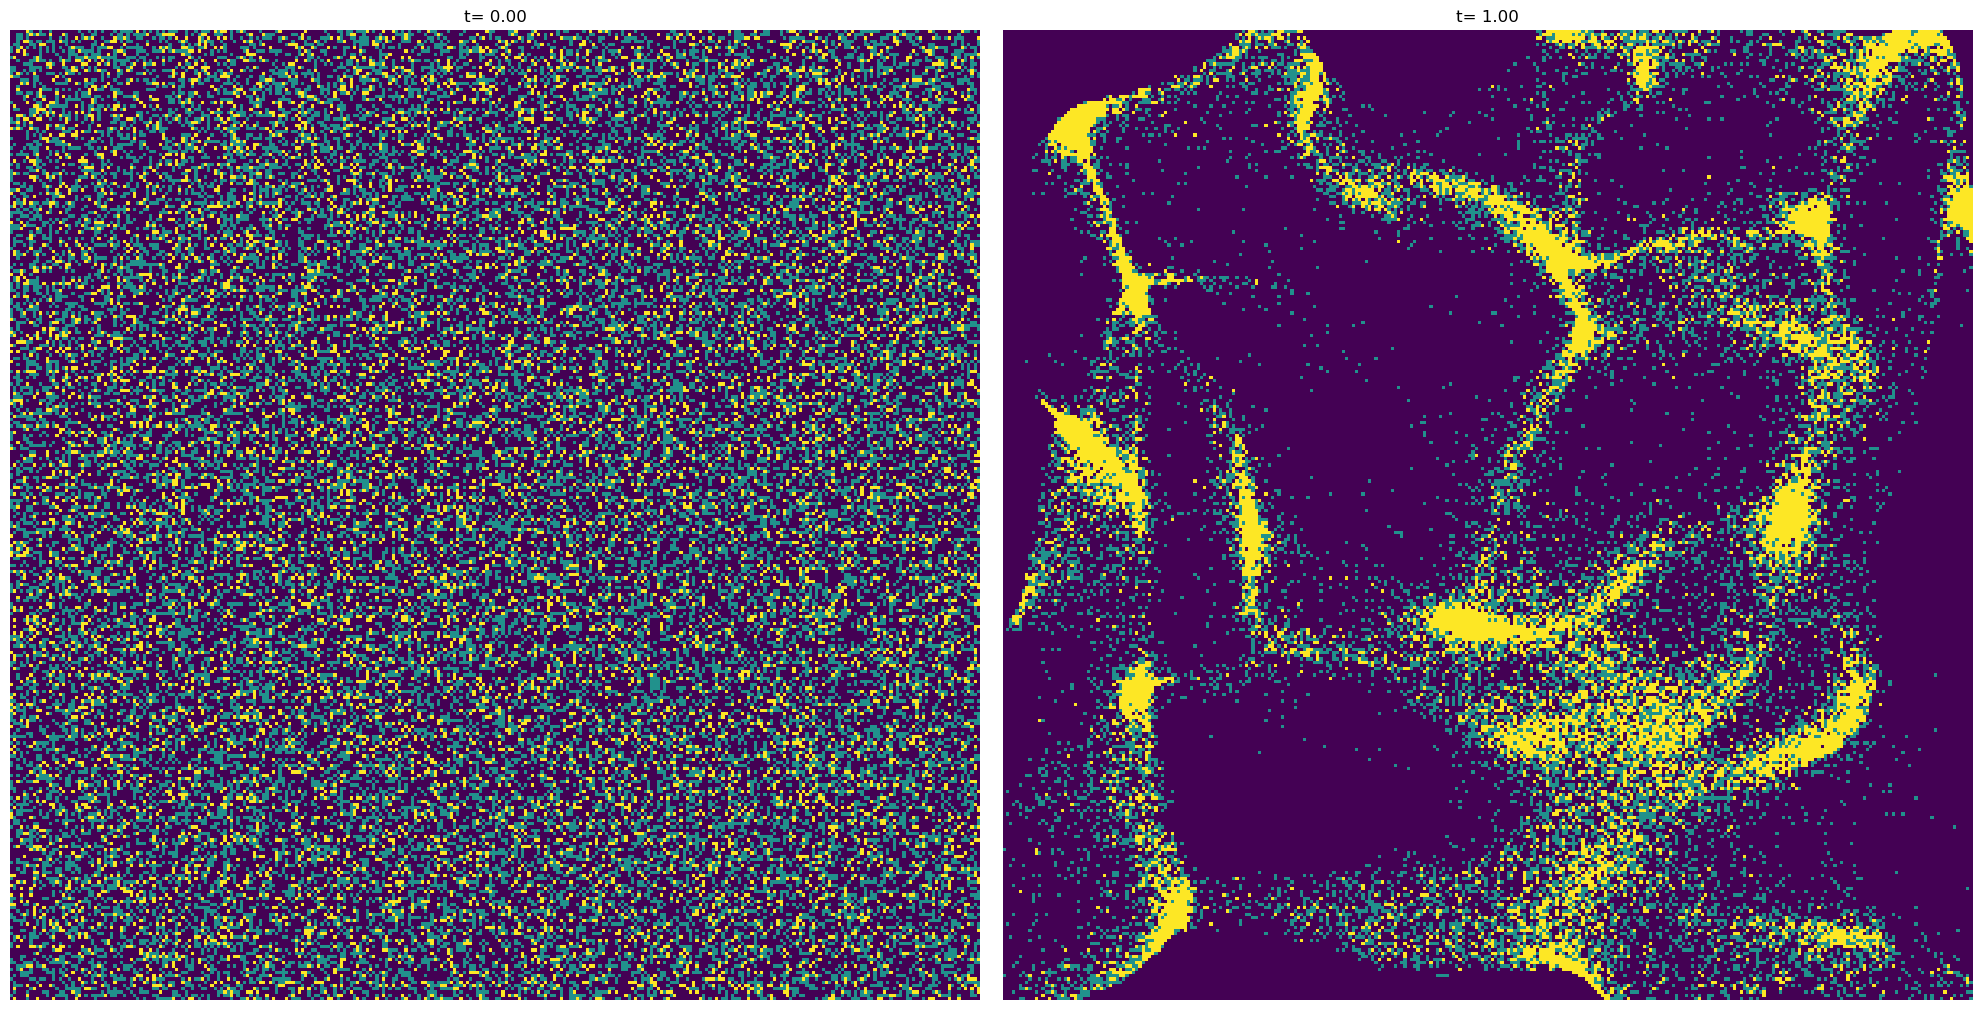

In [96]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# First frame (i=0)
H = ax1.hist2d(sol[0,:,0], sol[0,:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
cmax = 2
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
_ = ax1.hist2d(sol[0,:,0], sol[0,:,1], 300, range=((0,1), (0,1)), norm=norm)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('t= %.2f' % (T[0]))

# Last frame (i=9)
H = ax2.hist2d(sol[9,:,0], sol[9,:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
cmax = 2
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
_ = ax2.hist2d(sol[9,:,0], sol[9,:,1], 300, range=((0,1), (0,1)), norm=norm)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title('t= %.2f' % (T[9]))

plt.tight_layout()
plt.show()

## Compare to the true flow


In [84]:
start_points, end_points = data_gen.generate_batch(batch_size = batch_size, full=False)

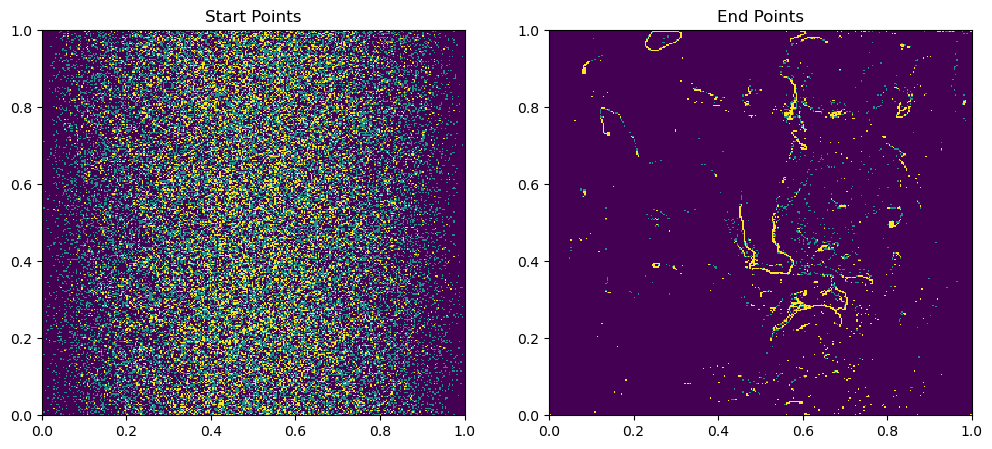

In [92]:
# Plot the start and end points side by side
fig, axs = plt.subplots(1, 2, figsize=(12,5))
norm = cm.colors.Normalize(vmax=2, vmin=0)
axs[0].hist2d(start_points[:,0], start_points[:,1], 300, range=((0,1), (0,1)), norm=norm)
axs[1].hist2d(end_points[:,0], end_points[:,1], 300, range=((0,1), (0,1)), norm=norm)
axs[0].set_title('Start Points')
axs[1].set_title('End Points')
plt.show()
